**Data Augmentation To Address Overfitting In Flower Classification CNN**

In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc

Credits: I used tensorflow offical tutorial: https://www.tensorflow.org/tutorials/images/classification as a reference and made bunch of changes to make it simpler

In below image, 4 new training samples are generated from original sample using different transformations

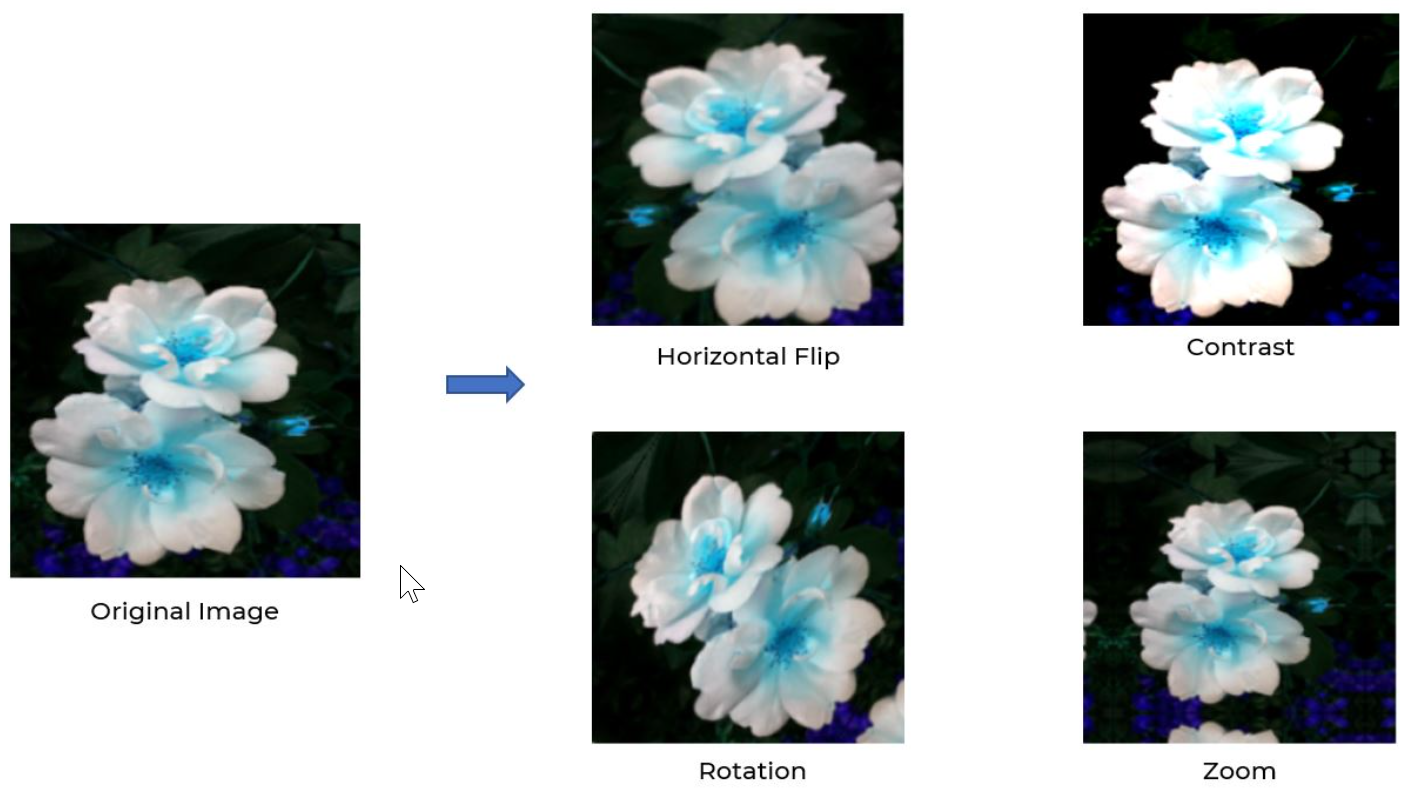

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

Load The Dataset

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 89s 0us/step


In [4]:
data_dir

'.\\datasets\\flower_photos'

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [7]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [9]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

To display images, we use the Pillow library

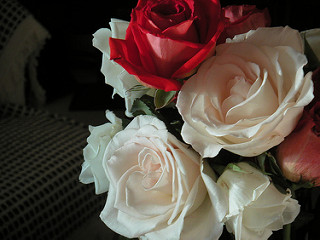

In [10]:
PIL.Image.open(str(roses[1]))

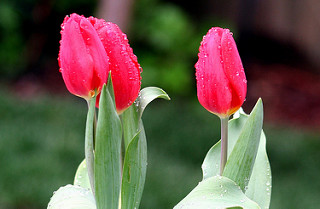

In [11]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

Read flowers images from disk into numpy array using opencv

In [12]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [13]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [14]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [15]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

opencv doesn't accept the window path object, therefore we converted it into a string using the str() function

In [17]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img

array([[[ 0, 15,  6],
        [ 0, 15,  6],
        [ 0, 17,  8],
        ...,
        [24, 51, 31],
        [25, 52, 32],
        [26, 53, 33]],

       [[ 7, 22, 14],
        [ 7, 22, 14],
        [ 6, 21, 13],
        ...,
        [20, 46, 30],
        [23, 49, 33],
        [25, 51, 35]],

       [[12, 23, 15],
        [12, 23, 15],
        [11, 22, 14],
        ...,
        [20, 42, 30],
        [23, 45, 33],
        [26, 48, 36]],

       ...,

       [[19, 30, 27],
        [14, 24, 18],
        [12, 20, 13],
        ...,
        [ 4, 13,  3],
        [ 0,  8,  1],
        [ 0,  5,  0]],

       [[19, 30, 28],
        [18, 27, 24],
        [15, 23, 16],
        ...,
        [ 3, 12,  2],
        [ 1,  9,  2],
        [ 0,  7,  2]],

       [[ 9, 19, 19],
        [17, 25, 24],
        [22, 29, 24],
        ...,
        [ 1, 12,  2],
        [ 2, 10,  3],
        [ 3, 11,  4]]], dtype=uint8)

In [18]:
img.shape

(240, 179, 3)

In [19]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

We need to resize the images because when training our model, we need all our images to be of the same size.

In [21]:
for flower_name, images in flowers_images_dict.items():
    print(flower_name)
    print(len(images))

roses
641
daisy
633
dandelion
898
sunflowers
699
tulips
799


In [20]:
X, Y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        Y.append(flowers_labels_dict[flower_name])

Now, Comverting simple plain python list into numpy array for our convenience

In [29]:
X = np.array(X)
Y = np.array(Y)

In [30]:
X[0]

array([[[ 1, 16,  7],
        [ 1, 16,  7],
        [ 1, 17,  9],
        ...,
        [23, 50, 31],
        [25, 51, 32],
        [26, 52, 33]],

       [[10, 23, 15],
        [10, 23, 15],
        [ 9, 22, 14],
        ...,
        [20, 44, 30],
        [23, 47, 33],
        [26, 50, 36]],

       [[13, 20, 13],
        [12, 20, 13],
        [11, 19, 12],
        ...,
        [21, 43, 30],
        [22, 45, 31],
        [25, 48, 34]],

       ...,

       [[12, 24, 18],
        [11, 22, 15],
        [12, 21, 11],
        ...,
        [ 7, 14,  7],
        [ 2,  8,  2],
        [ 0,  2,  0]],

       [[19, 30, 28],
        [16, 26, 21],
        [14, 22, 15],
        ...,
        [ 3, 12,  2],
        [ 0,  8,  1],
        [ 0,  6,  1]],

       [[11, 21, 20],
        [17, 25, 24],
        [21, 28, 23],
        ...,
        [ 1, 12,  2],
        [ 2, 10,  3],
        [ 3, 10,  4]]], dtype=uint8)

In [31]:
Y[:5]

array([0, 0, 0, 0, 0])

Train test split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [33]:
len(X_train)

2752

In [34]:
len(X_test)

918

Preprocessing : Scaling Images

In [35]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Build convolutional neural network and train it

In [36]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'), # we are using 16 filters of size 3*3 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'), # we are using 32 filters of size 3*3 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), # we are using 64 filters of size 3*3 
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)  # not using activation function, automatically linear activation will be used
]) 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, Y_train, epochs=30) 

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.3977 - loss: 1.3930
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 0.6030 - loss: 0.9928
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.6948 - loss: 0.7874
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.7955 - loss: 0.5562
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.8749 - loss: 0.3783
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9455 - loss: 0.1890
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9727 - loss: 0.0986
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.9706 - loss: 0.1083
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9867 - loss: 0.0517
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9926 - loss: 0.0336
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.9986 - loss: 0.0119
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 15

In [38]:
model.evaluate(X_test_scaled,Y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6670 - loss: 2.1167


[2.1294915676116943, 0.6753812432289124]

Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (66.70%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting

In [39]:
predictions = model.predict(X_test_scaled)
predictions

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


array([[ 10.275014  ,  21.86243   ,   2.0070732 , -12.890298  ,
         -1.7470996 ],
       [  7.493068  ,   1.4937251 ,  -7.8239956 ,  -4.823156  ,
          2.6401243 ],
       [ -4.583386  ,   7.607903  ,  17.577374  , -11.207567  ,
         -8.885169  ],
       ...,
       [  2.999753  , -11.086349  ,  -3.0684645 ,   9.555782  ,
          2.6935208 ],
       [  7.4066725 ,   4.555809  ,   3.0511022 ,  -4.3448653 ,
          0.31432313],
       [  1.1573657 , -13.28234   ,   3.1088805 ,   7.9188485 ,
          4.7144094 ]], dtype=float32)

In [40]:
score = tf.nn.softmax(predictions[0])

In [41]:
np.argmax(score)

1

In [42]:
Y_test[0]

1

Improve Test Accuracy Using Data Augmentation

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

C:\Users\ebrah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Original Image

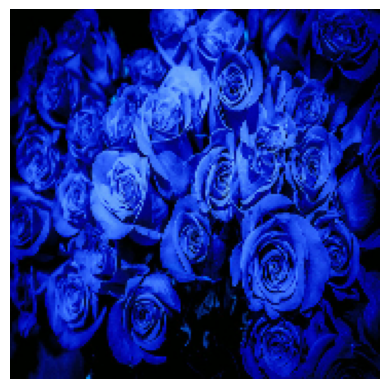

In [49]:
plt.axis('off')
plt.imshow(X[2])

Newly generated training sample using data augmentation

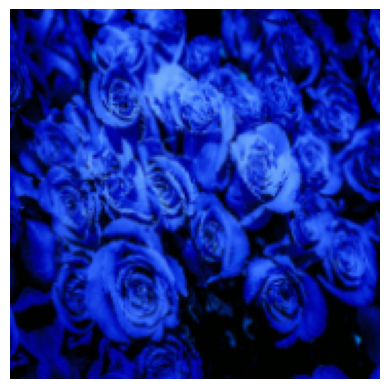

In [51]:
plt.axis('off')
plt.imshow(data_augmentation(X)[2].numpy().astype("uint8"))

Train the model using data augmentation and a drop out layer

In [52]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, Y_train, epochs=30)    

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.3477 - loss: 1.5413
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.5784 - loss: 1.0602
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.6150 - loss: 0.9867
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.6712 - loss: 0.8710
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.6777 - loss: 0.8210
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.7144 - loss: 0.7674
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.7224 - loss: 0.7464
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.7475 - loss: 0.6664
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.7560 - loss: 0.6408
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.7510 - loss: 0.6552
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.7822 - loss: 0.5883
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 19

In [53]:
model.evaluate(X_test_scaled,Y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7465 - loss: 0.9910


[0.9974797368049622, 0.7450980544090271]

You can see that by using data augmentation and drop out layer the accuracy of test set predictions is increased to 74.65%